In [1]:

import torch
from torch import nn
import numpy as np

# data handling
import wfdb
import pandas as pd

# graph plotting
%matplotlib ipympl
import matplotlib.pyplot as plt

import util
from util import QT_record


In [2]:

class Config():
    ds_path = 'qt-database-1.0.0'
    epochs = 30
    learning_rate = 1e-3

record_names = util.get_record_names(Config.ds_path)


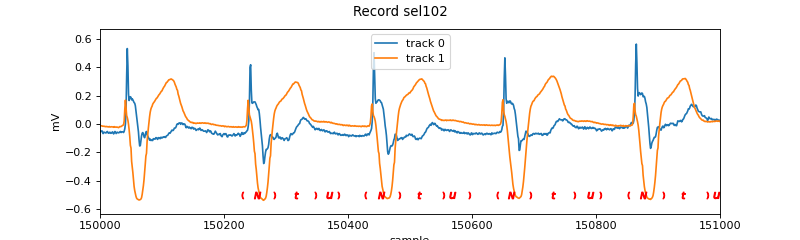

In [65]:
r = QT_record(Config.ds_path, record_names[1])
#r.check_bracket_mismatch(fix_mismatches=True)
r.normalize()
r.plot_ecg(start=150000, stop=151000)

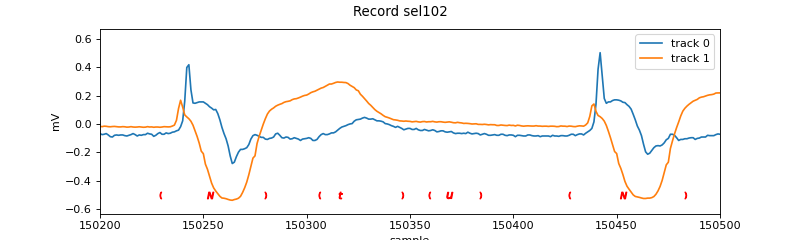

In [67]:
r = QT_record(Config.ds_path, record_names[1])
r.check_bracket_mismatch(fix_mismatches=True)
r.normalize()
r.plot_ecg(start=150200, stop=150500)


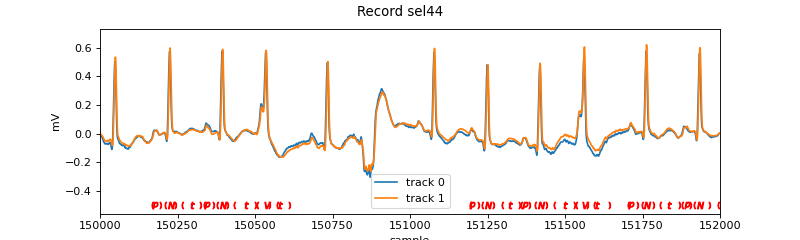

In [12]:
r = QT_record(Config.ds_path, record_names[50])
r.check_bracket_mismatch(fix_mismatches=True)
r.normalize()
r.plot_ecg(start=150000, stop=152000)

In [51]:

import copy

def clone(obj):
    return copy.deepcopy(obj)

class FCN(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        # out = (in - kern) / stride + 1
        # input: 1x200
        # output neuron should have a receptive field size of 150 or more

        self.conv = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=3, padding=0),   # 66
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=0),   # 64 
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=0),   # 62
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # 31
            
            nn.Conv1d(64, 64, kernel_size=5, stride=2, padding=0),   # 14
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=0),   # 12
            nn.Conv1d(64, 64, kernel_size=3, stride=1, padding=0),   # 10
            nn.LeakyReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # 5

            nn.Conv1d(64, 64, kernel_size=5, stride=1, padding=0),   # 1
        )

        # conv.out: 64x1

        f_prob = nn.Sequential(
            nn.Conv1d(64, 2, kernel_size=1),
            nn.Softmax(dim=1),
        )
        f_peak = nn.Conv1d(64, 1, kernel_size=1)

        #self.p_prob = clone(f_prob)
        #self.p_peak = clone(f_peak)
        self.q_prob = clone(f_prob)
        self.q_peak = clone(f_peak)
        #self.t_prob = clone(f_prob)
        #self.t_peak = clone(f_peak)

        """
        self.pps = nn.Sequential(
            nn.Conv1d(64, 6, kernel_size=1),
            nn.LeakyReLU(),
        )
        """
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        q_prob = self.q_prob(x)
        q_peak = self.q_peak(x)
        return q_prob.view(q_prob.size(0), 2), q_peak.view(q_peak.size(0), 1)



In [57]:
net = FCN()
x = torch.rand(100,1,200)
y = net(x)
print("net output shape: {}".format(y[0].shape))
y_prob = torch.rand(100,2)
y_peak = torch.rand(100,1)

net output shape: torch.Size([100, 2])


In [61]:
crit = nn.CrossEntropyLoss()
#crit = nn.MSELoss()
crit(y[0], y_prob)

tensor(0.6626, grad_fn=<DivBackward1>)

In [50]:
sf = nn.Softmax(dim=1)
sf(y_prob)

tensor([[0.5465, 0.4535]])